In [ ]:
import pandas as pd
import json
import numpy as np
from scipy.stats import shapiro, spearmanr, pearsonr


answers = pd.read_csv("Like a book_June 10, 2025_13.46.csv")

with open("firestore-export (1).json", "r") as f:
    time_logs = json.load(f)["sessions"]

valid_ids = []
actual_time_std = {}

for uid, session in time_logs.items():
    std_times = session.get("standardTime", [])
    met_times = session.get("metaphorTime", [])

    if len(std_times) == 2 and len(met_times) == 2:
        valid_ids.append(uid)
        actual_time_std[uid] = sum(std_times)

answers.columns = answers.columns.str.strip()

answers["id"] = answers["v"].astype(str)
answers = answers[answers["id"].isin(valid_ids)]

scale_map = {
    "Very short": 1,
    "Short": 2,
    "Neutral": 3,
    "Long": 4,
    "Very long": 5
}

answers["Q7_numeric"] = answers["Q7"].map(scale_map)

answers["actual_time_std"] = answers["id"].map(actual_time_std)

def minmax_normalize(series):
    return (series - series.min()) / (series.max() - series.min()) * 4 + 1

answers["actual_std_scaled"] = minmax_normalize(answers["actual_time_std"])

answers["gap"] = (answers["Q7_numeric"] - answers["actual_std_scaled"]).abs()
answers["satisfaction"] = answers["Q7_numeric"]

clean_data = answers[["gap", "satisfaction"]].dropna()

print("Clean data points available:", len(clean_data))
print(clean_data.head())

if len(clean_data) >= 3:
    gap_stat, gap_p = shapiro(clean_data["gap"])
    satis_stat, satis_p = shapiro(clean_data["satisfaction"])

    print("\n📊 Shapiro-Wilk Test (Normality):")
    print(f"Gap: p = {gap_p:.4f}")
    print(f"Satisfaction: p = {satis_p:.4f}")

    if gap_p > 0.05 and satis_p > 0.05:
        corr_type = "Pearson"
        corr, pval = pearsonr(clean_data["gap"], clean_data["satisfaction"])
    else:
        corr_type = "Spearman"
        corr, pval = spearmanr(clean_data["gap"], clean_data["satisfaction"])

    print(f"\n🔗 {corr_type} correlation between time gap and satisfaction:")
    print(f"Correlation = {corr:.3f}, p = {pval:.4f}")

    if pval < 0.05:
        print("Significant correlation (reject H0)")
    else:
        print("No significant correlation (fail to reject H0)")
else:
    print("Not enough clean data to perform statistical analysis.")


✅ Clean data points available: 0
Empty DataFrame
Columns: [gap, satisfaction]
Index: []
❗ Not enough clean data to perform statistical analysis.


In [ ]:
import pandas as pd
import json
import numpy as np
from scipy.stats import shapiro, spearmanr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

answers = pd.read_csv("Like a book_June 10, 2025_13.46.csv")

with open("firestore-export (1).json", "r") as f:
    time_logs = json.load(f)["sessions"]

valid_ids = []
actual_time_std = {}
actual_time_met = {}

for uid, session in time_logs.items():
    std = session.get("standardTime", [])
    met = session.get("metaphorTime", [])

    if len(std) == 2 and len(met) == 2:
        valid_ids.append(uid)
        actual_time_std[uid] = sum(std)
        actual_time_met[uid] = sum(met)
print("Number of valid entries:", len(valid_ids))

answers.columns = answers.columns.str.strip()
answers["id"] = answers["ResponseId"].astype(str)
answers = answers[answers["id"].isin(valid_ids)]

scale_map = {
    "Very short": 1,
    "Short": 2,
    "Neutral": 3,
    "Long": 4,
    "Very long": 5
}

answers["Q7_numeric"] = answers["Q7"].map(scale_map)
answers["Q23_numeric"] = answers["Q23"].map(scale_map)

answers["actual_std"] = answers["id"].map(actual_time_std)
answers["actual_met"] = answers["id"].map(actual_time_met)

def minmax_normalize(series):
    return (series - series.min()) / (series.max() - series.min()) * 4 + 1

answers["actual_std_scaled"] = minmax_normalize(answers["actual_std"])
answers["actual_met_scaled"] = minmax_normalize(answers["actual_met"])

answers["gap_std"] = (answers["Q7_numeric"] - answers["actual_std_scaled"]).abs()
answers["gap_met"] = (answers["Q23_numeric"] - answers["actual_met_scaled"]).abs()

def test_correlation(gap_col, sat_col, label):
    data = answers[[gap_col, sat_col]].dropna()
    print(f"\nInterface: {label} | Data points: {len(data)}")

    if len(data) < 3:
        print("Not enough data to run statistical tests.")
        return

    g_p = shapiro(data[gap_col]).pvalue
    s_p = shapiro(data[sat_col]).pvalue
    print(f"Shapiro-Wilk p-values -> Gap: {g_p:.4f}, Satisfaction: {s_p:.4f}")

    if g_p > 0.05 and s_p > 0.05:
        corr, pval = pearsonr(data[gap_col], data[sat_col])
        method = "Pearson"
    else:
        corr, pval = spearmanr(data[gap_col], data[sat_col])
        method = "Spearman"

    print(f"{method} Correlation = {corr:.3f}, p = {pval:.4f}")
    if pval < 0.05:
        print("Significant correlation (reject H0)")
    else:
        print("No significant correlation (fail to reject H0)")

test_correlation("gap_std", "Q7_numeric", "Standard Interface (Q7)")
test_correlation("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")

def plot_regression(gap_col, sat_col, label):
    data = answers[[gap_col, sat_col]].dropna()
    if len(data) < 3:
        print(f"Not enough data to plot regression for {label}")
        return

    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=gap_col,
        y=sat_col,
        data=data,
        scatter_kws={"s": 50, "alpha": 0.7},
        line_kws={"color": "red"},
    )
    plt.title(f"Regression: Gap vs. Satisfaction\n{label}")
    plt.xlabel("Gap (|Perceived - Actual|)")
    plt.ylabel("Perceived Duration (Satisfaction)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_regression("gap_std", "Q7_numeric", "Standard Interface (Q7)")
plot_regression("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")


Number of valid entries: 29

📊 Interface: Standard Interface (Q7) | Data points: 0
❗ Not enough data to run statistical tests.

📊 Interface: Metaphor Interface (Q23) | Data points: 0
❗ Not enough data to run statistical tests.
❗ Not enough data to plot regression for Standard Interface (Q7)
❗ Not enough data to plot regression for Metaphor Interface (Q23)


In [ ]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, spearmanr, pearsonr

answers = pd.read_csv("Like a book_June 10, 2025_13.46.csv")

with open("firestore-export (1).json", "r") as f:
    time_logs = json.load(f)["sessions"]

valid_ids = []
actual_time_std = {}
actual_time_met = {}

for uid, session in time_logs.items():
    std = session.get("standardTime", [])
    met = session.get("metaphorTime", [])

    if len(std) == 2 and len(met) == 2:
        valid_ids.append(uid)
        actual_time_std[uid] = sum(std)
        actual_time_met[uid] = sum(met)

print("Number of valid entries:", len(valid_ids))

answers.columns = answers.columns.str.strip()
answers["id"] = answers["ResponseId"].astype(str).str.strip()
answers = answers[answers["id"].isin(valid_ids)]

scale_map_clean = {
    "very short": 1,
    "short": 2,
    "neutral": 3,
    "long": 4,
    "very long": 5
}

answers["Q7_numeric"] = answers["Q7"].astype(str).str.strip().str.lower().map(scale_map_clean)
answers["Q23_numeric"] = answers["Q23"].astype(str).str.strip().str.lower().map(scale_map_clean)

print("Unmapped Q7 values:", answers[answers["Q7_numeric"].isna()]["Q7"].unique())
print("Unmapped Q23 values:", answers[answers["Q23_numeric"].isna()]["Q23"].unique())

answers["actual_std"] = answers["id"].map(actual_time_std)
answers["actual_met"] = answers["id"].map(actual_time_met)

def minmax_normalize(series):
    return (series - series.min()) / (series.max() - series.min()) * 4 + 1

answers["actual_std_scaled"] = minmax_normalize(answers["actual_std"])
answers["actual_met_scaled"] = minmax_normalize(answers["actual_met"])

answers["gap_std"] = (answers["Q7_numeric"] - answers["actual_std_scaled"]).abs()
answers["gap_met"] = (answers["Q23_numeric"] - answers["actual_met_scaled"]).abs()

def test_correlation(gap_col, sat_col, label):
    data = answers[[gap_col, sat_col]].dropna()
    print(f"\nInterface: {label} | Data points: {len(data)}")

    if len(data) < 3:
        print("Not enough data to run statistical tests.")
        return

    g_p = shapiro(data[gap_col]).pvalue
    s_p = shapiro(data[sat_col]).pvalue
    print(f"Shapiro-Wilk p-values -> Gap: {g_p:.4f}, Satisfaction: {s_p:.4f}")

    if g_p > 0.05 and s_p > 0.05:
        corr, pval = pearsonr(data[gap_col], data[sat_col])
        method = "Pearson"
    else:
        corr, pval = spearmanr(data[gap_col], data[sat_col])
        method = "Spearman"

    print(f"{method} Correlation = {corr:.3f}, p = {pval:.4f}")
    if pval < 0.05:
        print("Significant correlation (reject H0)")
    else:
        print("No significant correlation (fail to reject H0)")

def plot_regression(gap_col, sat_col, label):
    data = answers[[gap_col, sat_col]].dropna()
    if len(data) < 3:
        print(f"Not enough data to plot regression for {label}")
        return

    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=gap_col,
        y=sat_col,
        data=data,
        scatter_kws={"s": 50, "alpha": 0.7},
        line_kws={"color": "red"},
    )
    plt.title(f"Regression: Gap vs. Satisfaction\n{label}")
    plt.xlabel("Gap (|Perceived - Actual|)")
    plt.ylabel("Perceived Duration (Satisfaction)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

test_correlation("gap_std", "Q7_numeric", "Standard Interface (Q7)")
plot_regression("gap_std", "Q7_numeric", "Standard Interface (Q7)")

test_correlation("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")
plot_regression("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")


✅ Number of valid entries: 29
❓ Unmapped Q7 values: []
❓ Unmapped Q23 values: []

📊 Interface: Standard Interface (Q7) | Data points: 0
❗ Not enough data to run statistical tests.
❗ Not enough data to plot regression for Standard Interface (Q7)

📊 Interface: Metaphor Interface (Q23) | Data points: 0
❗ Not enough data to run statistical tests.
❗ Not enough data to plot regression for Metaphor Interface (Q23)


In [ ]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, spearmanr, pearsonr

with open("new.json", "r") as f:
    answers = pd.DataFrame(json.load(f))

with open("firestore-export (1).json", "r") as f:
    time_logs = json.load(f)["sessions"]

valid_ids = []
actual_time_std = {}
actual_time_met = {}

for uid, session in time_logs.items():
    std = session.get("standardTime", [])
    met = session.get("metaphorTime", [])
    if len(std) == 2 and len(met) == 2:
        valid_ids.append(uid)
        actual_time_std[uid] = sum(std)
        actual_time_met[uid] = sum(met)

print("Valid entries:", len(valid_ids))

answers["id"] = answers["ResponseId"].astype(str).str.strip()
answers = answers[answers["id"].isin(valid_ids)]

scale_map = {
    "Very short": 1,
    "Short": 2,
    "Neutral": 3,
    "Long": 4,
    "Very long": 5
}

answers["Q7_numeric"] = answers["Q7"].map(scale_map)
answers["Q23_numeric"] = answers["Q23"].map(scale_map)

answers["actual_std"] = answers["id"].map(actual_time_std)
answers["actual_met"] = answers["id"].map(actual_time_met)

def minmax_normalize(series):
    return (series - series.min()) / (series.max() - series.min()) * 4 + 1

answers["actual_std_scaled"] = minmax_normalize(answers["actual_std"])
answers["actual_met_scaled"] = minmax_normalize(answers["actual_met"])

answers["gap_std"] = (answers["Q7_numeric"] - answers["actual_std_scaled"]).abs()
answers["gap_met"] = (answers["Q23_numeric"] - answers["actual_met_scaled"]).abs()

def test_correlation(gap_col, sat_col, label):
    data = answers[[gap_col, sat_col]].dropna()
    print(f"\n{label} | Data points: {len(data)}")
    if len(data) < 3:
        print("Not enough data to run statistical tests.")
        return
    g_p = shapiro(data[gap_col]).pvalue
    s_p = shapiro(data[sat_col]).pvalue
    print(f"Shapiro-Wilk p-values → Gap: {g_p:.4f}, Satisfaction: {s_p:.4f}")
    if g_p > 0.05 and s_p > 0.05:
        corr, pval = pearsonr(data[gap_col], data[sat_col])
        method = "Pearson"
    else:
        corr, pval = spearmanr(data[gap_col], data[sat_col])
        method = "Spearman"
    print(f"{method} correlation = {corr:.3f}, p = {pval:.4f}")
    print("Significant" if pval < 0.05 else "Not significant")

def plot_regression(gap_col, sat_col, label):
    data = answers[[gap_col, sat_col]].dropna()
    if len(data) < 3:
        print(f"Not enough data to plot regression for {label}")
        return
    sns.regplot(x=gap_col, y=sat_col, data=data, scatter_kws={"alpha": 0.7})
    plt.title(f"Regression: {label}")
    plt.xlabel("Gap (|Perceived - Actual|)")
    plt.ylabel("Perceived Duration (1–5)")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

test_correlation("gap_std", "Q7_numeric", "Standard Interface (Q7)")
plot_regression("gap_std", "Q7_numeric", "Standard Interface (Q7)")

test_correlation("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")
plot_regression("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")


✅ Valid entries: 29

📊 Standard Interface (Q7) | Data points: 0
❗ Not enough data to run statistical tests.
❗ Not enough data to plot regression for Standard Interface (Q7)

📊 Metaphor Interface (Q23) | Data points: 0
❗ Not enough data to run statistical tests.
❗ Not enough data to plot regression for Metaphor Interface (Q23)


✅ Valid time log entries: 29
⚠️ Warning: 30 survey responses vs 29 time logs. Trimming to min length.

📊 Standard Interface (Q7) | Data points: 29
Shapiro-Wilk p-values → Gap: 0.0171, Satisfaction: 0.0008
Spearman correlation = 0.694, p = 0.0000
✅ Significant


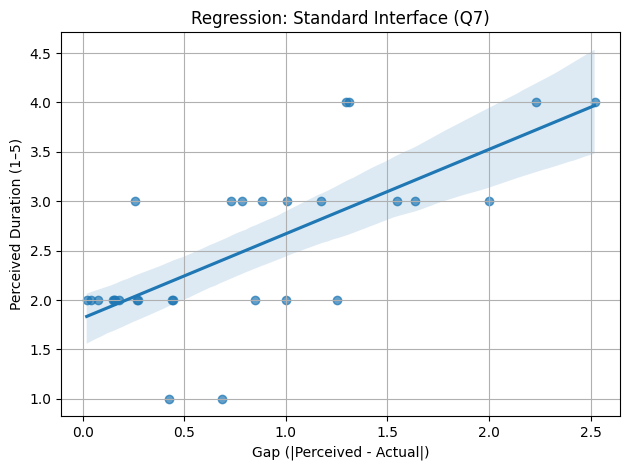


📊 Metaphor Interface (Q23) | Data points: 29
Shapiro-Wilk p-values → Gap: 0.0506, Satisfaction: 0.0023
Spearman correlation = 0.689, p = 0.0000
✅ Significant


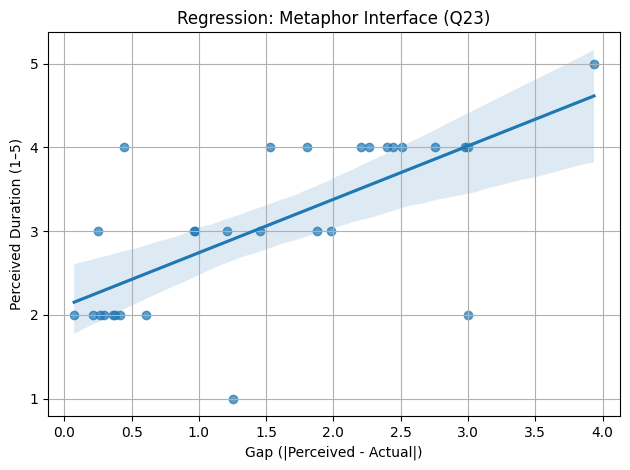

In [ ]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, spearmanr, pearsonr

with open("new.json", "r") as f:
    answers = pd.DataFrame(json.load(f))

with open("firestore-export (1).json", "r") as f:
    time_logs = json.load(f)["sessions"]

valid_entries = []
for uid, session in time_logs.items():
    std = session.get("standardTime", [])
    met = session.get("metaphorTime", [])
    if len(std) == 2 and len(met) == 2:
        valid_entries.append({
            "uid": uid,
            "actual_std": sum(std),
            "actual_met": sum(met)
        })

valid_df = pd.DataFrame(valid_entries)
print("Valid time log entries:", len(valid_df))

if len(answers) != len(valid_df):
    print(f"⚠Warning: {len(answers)} survey responses vs {len(valid_df)} time logs. Trimming to min length.")
    min_len = min(len(answers), len(valid_df))
    answers = answers.iloc[:min_len]
    valid_df = valid_df.iloc[:min_len]

combined = pd.concat([answers.reset_index(drop=True), valid_df.reset_index(drop=True)], axis=1)

scale_map = {
    "Very short": 1,
    "Short": 2,
    "Neutral": 3,
    "Long": 4,
    "Very long": 5
}

combined["Q7_numeric"] = combined["Q7"].map(scale_map)
combined["Q23_numeric"] = combined["Q23"].map(scale_map)

def minmax_normalize(series):
    return (series - series.min()) / (series.max() - series.min()) * 4 + 1

combined["actual_std_scaled"] = minmax_normalize(combined["actual_std"])
combined["actual_met_scaled"] = minmax_normalize(combined["actual_met"])

combined["gap_std"] = (combined["Q7_numeric"] - combined["actual_std_scaled"]).abs()
combined["gap_met"] = (combined["Q23_numeric"] - combined["actual_met_scaled"]).abs()

def test_correlation(gap_col, sat_col, label):
    data = combined[[gap_col, sat_col]].dropna()
    print(f"\n{label} | Data points: {len(data)}")
    if len(data) < 3:
        print("Not enough data to run statistical tests.")
        return
    g_p = shapiro(data[gap_col]).pvalue
    s_p = shapiro(data[sat_col]).pvalue
    print(f"Shapiro-Wilk p-values → Gap: {g_p:.4f}, Satisfaction: {s_p:.4f}")
    if g_p > 0.05 and s_p > 0.05:
        corr, pval = pearsonr(data[gap_col], data[sat_col])
        method = "Pearson"
    else:
        corr, pval = spearmanr(data[gap_col], data[sat_col])
        method = "Spearman"
    print(f"{method} correlation = {corr:.3f}, p = {pval:.4f}")
    print("Significant" if pval < 0.05 else "Not significant")

def plot_regression(gap_col, sat_col, label):
    data = combined[[gap_col, sat_col]].dropna()
    if len(data) < 3:
        print(f"Not enough data to plot regression for {label}")
        return
    sns.regplot(x=gap_col, y=sat_col, data=data, scatter_kws={"alpha": 0.7})
    plt.title(f"Regression: {label}")
    plt.xlabel("Gap (|Perceived - Actual|)")
    plt.ylabel("Perceived Duration (1–5)")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

test_correlation("gap_std", "Q7_numeric", "Standard Interface (Q7)")
plot_regression("gap_std", "Q7_numeric", "Standard Interface (Q7)")

test_correlation("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")
plot_regression("gap_met", "Q23_numeric", "Metaphor Interface (Q23)")

✅ Valid time log entries: 29

📊 Standard Interface: Gap vs SUS | Data points: 29
Spearman correlation = -0.561, p = 0.0015
❌ Contradicts H3: Negative correlation

📊 Metaphor Interface: Gap vs SUS | Data points: 29
Spearman correlation = -0.371, p = 0.0475
❌ Contradicts H3: Negative correlation


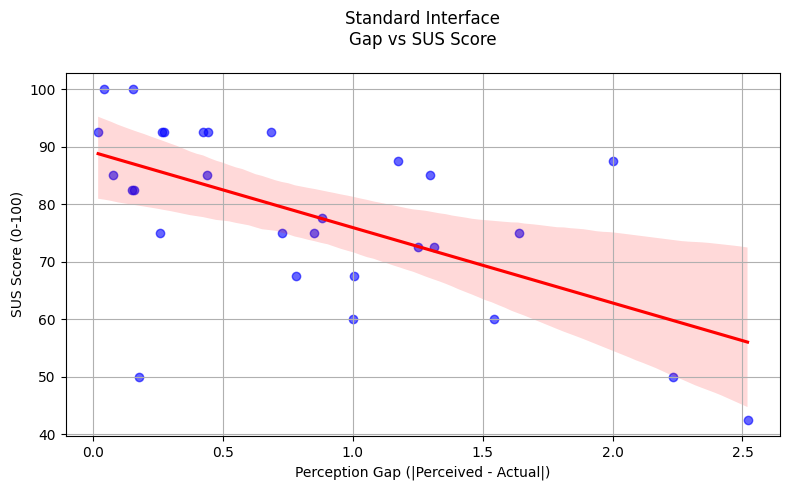

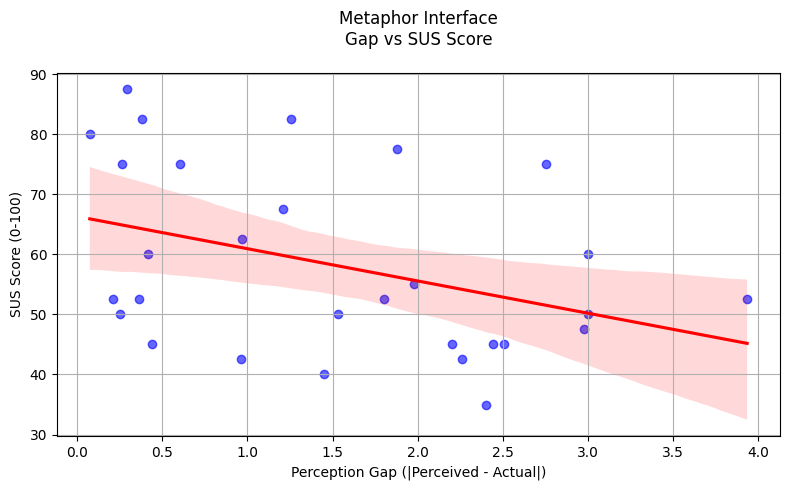


💾 Saved combined data to 'combined_analysis_data.csv'


In [ ]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, spearmanr, pearsonr

with open("firestore-export (1).json", "r") as f:
    time_logs = json.load(f)["sessions"]

with open("new.json", "r") as f:
    answers = pd.DataFrame(json.load(f))

with open("sus.json", "r") as f:
    sus_scores = pd.DataFrame(json.load(f))

valid_entries = []
for uid, session in time_logs.items():
    std = session.get("standardTime", [])
    met = session.get("metaphorTime", [])
    if len(std) == 2 and len(met) == 2:
        valid_entries.append({
            "uid": uid,
            "actual_std": sum(std),
            "actual_met": sum(met)
        })

valid_df = pd.DataFrame(valid_entries)
print(f"Valid time log entries: {len(valid_df)}")

min_len = min(len(answers), len(valid_df), len(sus_scores))
answers = answers.iloc[:min_len]
valid_df = valid_df.iloc[:min_len]
sus_scores = sus_scores.iloc[:min_len]

combined = pd.concat([
    answers.reset_index(drop=True),
    valid_df.reset_index(drop=True),
    sus_scores.reset_index(drop=True)
], axis=1)

time_scale = {
    "Very short": 1,
    "Short": 2,
    "Neutral": 3,
    "Long": 4,
    "Very long": 5
}
combined["Q7_numeric"] = combined["Q7"].map(time_scale)
combined["Q23_numeric"] = combined["Q23"].map(time_scale)

def minmax_normalize(series):
    return (series - series.min()) / (series.max() - series.min()) * 4 + 1

combined["actual_std_scaled"] = minmax_normalize(combined["actual_std"])
combined["actual_met_scaled"] = minmax_normalize(combined["actual_met"])

combined["gap_std"] = (combined["Q7_numeric"] - combined["actual_std_scaled"]).abs()
combined["gap_met"] = (combined["Q23_numeric"] - combined["actual_met_scaled"]).abs()

def test_correlation(gap_col, sus_col, label):
    data = combined[[gap_col, sus_col]].dropna()
    print(f"\n{label} | Data points: {len(data)}")

    if len(data) < 3:
        print("Not enough data for statistical tests")
        return

    gap_normal = shapiro(data[gap_col]).pvalue > 0.05
    sus_normal = shapiro(data[sus_col]).pvalue > 0.05

    if gap_normal and sus_normal:
        corr, pval = pearsonr(data[gap_col], data[sus_col])
        method = "Pearson"
    else:
        corr, pval = spearmanr(data[gap_col], data[sus_col])
        method = "Spearman"

    print(f"{method} correlation = {corr:.3f}, p = {pval:.4f}")

    if pval < 0.05:
        if corr > 0:
            print("Supports H3: Positive correlation (gap ↑ → satisfaction ↑)")
        else:
            print("Contradicts H3: Negative correlation")
    else:
        print("No significant correlation (Cannot reject H0)")

test_correlation("gap_std", "SUS_A", "Standard Interface: Gap vs SUS")
test_correlation("gap_met", "SUS_B", "Metaphor Interface: Gap vs SUS")

def plot_relationship(gap_col, sus_col, title):
    plt.figure(figsize=(8, 5))
    sns.regplot(
        x=gap_col,
        y=sus_col,
        data=combined,
        scatter_kws={"alpha": 0.6, "color": "blue"},
        line_kws={"color": "red"}
    )
    plt.title(f"{title}\nGap vs SUS Score", pad=20)
    plt.xlabel("Perception Gap (|Perceived - Actual|)")
    plt.ylabel("SUS Score (0-100)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_relationship("gap_std", "SUS_A", "Standard Interface")
plot_relationship("gap_met", "SUS_B", "Metaphor Interface")

combined.to_csv("combined_analysis_data.csv", index=False)
print("\nSaved combined data to 'combined_analysis_data.csv'")